Baseline Accuracy: 0.8570258650105781
Baseline DP Difference (Sex): 0.18086582694388684
Baseline EO Difference (Sex): 0.0931644107807007
Mitigated Accuracy: 0.8398280215655497
Mitigated DP Difference (Sex): 0.01893292173701419
Mitigated EO Difference (Sex): 0.2956676799755447


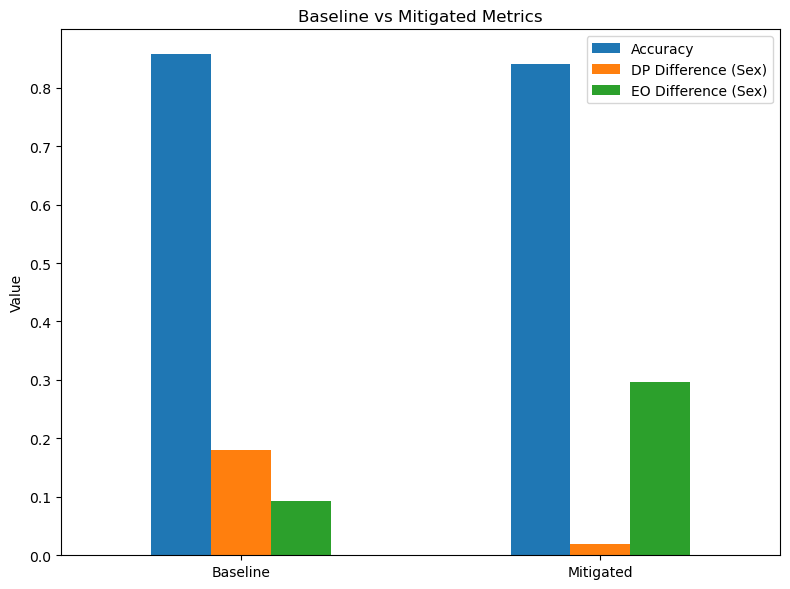

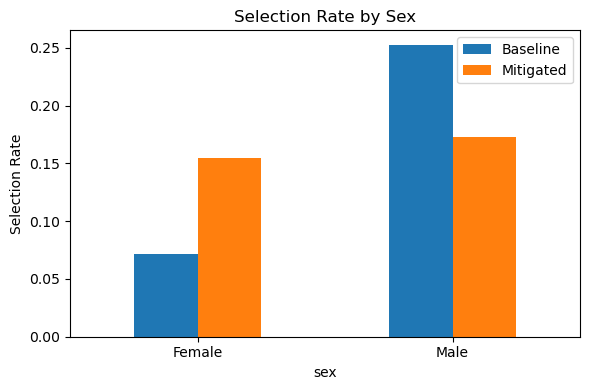

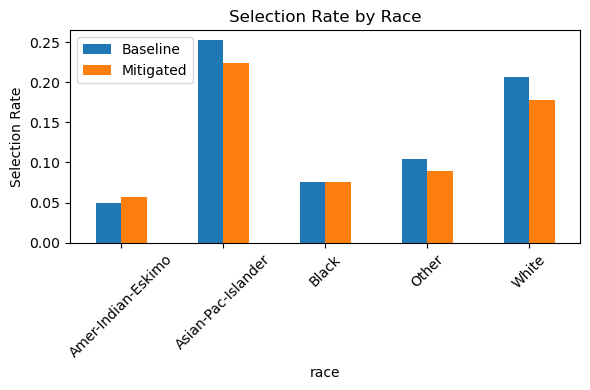

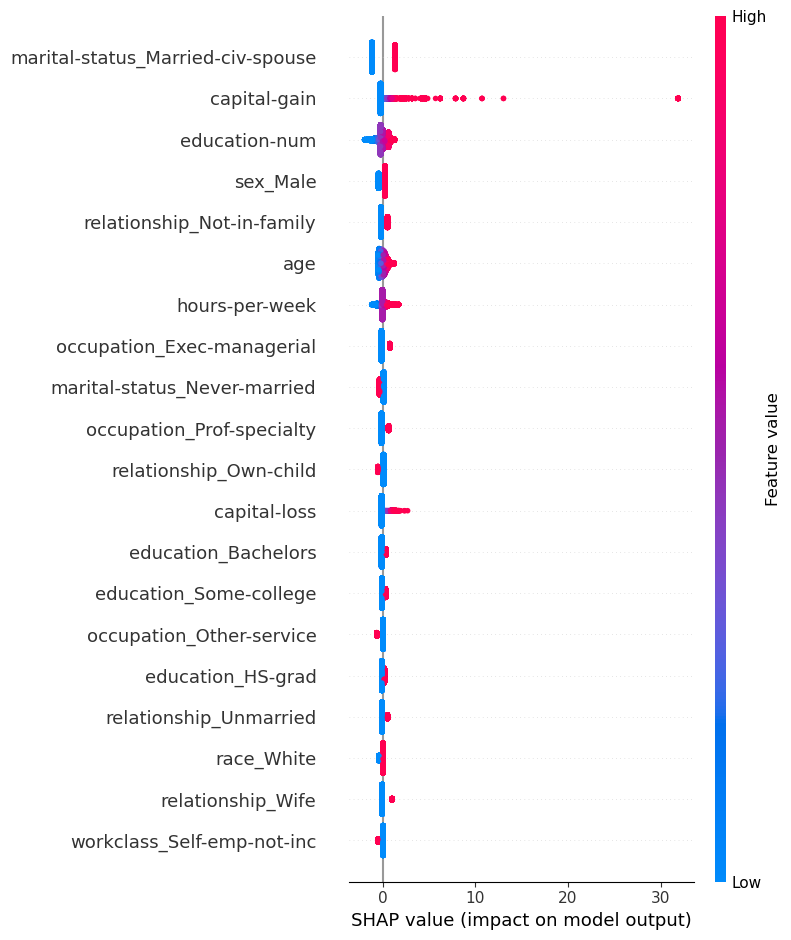

Notebook complete: all plots saved in ../results/ and shown inline.


In [1]:
# FairLens: Bias & Fairness Detection in Machine Learning
# Author: Mohit Tiwary

# =========================
# 1. Imports
# =========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

import shap
from sklearn.datasets import fetch_openml

# =========================
# 2. Setup Results Folder
# =========================
os.makedirs("../results", exist_ok=True)

# =========================
# 3. Load Dataset (OpenML)
# =========================
adult = fetch_openml(name='adult', version=2, as_frame=True)
data = adult.frame

# Target column is 'class'
X = data.drop(columns=["class"])
y = (data["class"] == ">50K").astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# =========================
# 4. Preprocessing
# =========================
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 5. Baseline Model
# =========================
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

dp_diff_baseline = demographic_parity_difference(y_test, y_pred_baseline, sensitive_features=data.loc[y_test.index, "sex"])
eo_diff_baseline = equalized_odds_difference(y_test, y_pred_baseline, sensitive_features=data.loc[y_test.index, "sex"])

print("Baseline Accuracy:", baseline_acc)
print("Baseline DP Difference (Sex):", dp_diff_baseline)
print("Baseline EO Difference (Sex):", eo_diff_baseline)

# =========================
# 6. Mitigation (Exponentiated Gradient)
# =========================
constraint = DemographicParity()
mitigator = ExponentiatedGradient(baseline_model, constraints=constraint)
mitigator.fit(X_train_scaled, y_train, sensitive_features=data.loc[y_train.index, "sex"])

y_pred_mitigated = mitigator.predict(X_test_scaled)
mitigated_acc = accuracy_score(y_test, y_pred_mitigated)

dp_diff_mitigated = demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=data.loc[y_test.index, "sex"])
eo_diff_mitigated = equalized_odds_difference(y_test, y_pred_mitigated, sensitive_features=data.loc[y_test.index, "sex"])

print("Mitigated Accuracy:", mitigated_acc)
print("Mitigated DP Difference (Sex):", dp_diff_mitigated)
print("Mitigated EO Difference (Sex):", eo_diff_mitigated)

# =========================
# 7. Fairness Metrics Plot
# =========================
metrics = {
    "Accuracy": [baseline_acc, mitigated_acc],
    "DP Difference (Sex)": [dp_diff_baseline, dp_diff_mitigated],
    "EO Difference (Sex)": [eo_diff_baseline, eo_diff_mitigated]
}

df_metrics = pd.DataFrame(metrics, index=["Baseline", "Mitigated"])
df_metrics.plot(kind="bar", figsize=(8,6))
plt.title("Baseline vs Mitigated Metrics")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("../results/baseline_vs_mitigated_metrics.png")
plt.show()

# =========================
# 8. Selection Rate by Sex
# =========================
sex_baseline = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=data.loc[y_test.index, "sex"]
)

sex_mitigated = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=data.loc[y_test.index, "sex"]
)

df_sex = pd.DataFrame({
    "Baseline": sex_baseline.by_group,
    "Mitigated": sex_mitigated.by_group
})

df_sex.plot(kind="bar", figsize=(6,4))
plt.title("Selection Rate by Sex")
plt.ylabel("Selection Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../results/fairness_sex.png")
plt.show()

# =========================
# 9. Selection Rate by Race
# =========================
race_baseline = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=data.loc[y_test.index, "race"]
)

race_mitigated = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=data.loc[y_test.index, "race"]
)

df_race = pd.DataFrame({
    "Baseline": race_baseline.by_group,
    "Mitigated": race_mitigated.by_group
})

df_race.plot(kind="bar", figsize=(6,4))
plt.title("Selection Rate by Race")
plt.ylabel("Selection Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/fairness_race.png")
plt.show()

# =========================
# 10. SHAP Explainability
# =========================
explainer = shap.LinearExplainer(baseline_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# --- SHAP Summary Plot (dot swarm) ---
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)   # generate but don't auto-display
plt.savefig("../results/shap_summary.png", bbox_inches="tight")  # save to results
plt.show()  # now display inline

print("Notebook complete: all plots saved in ../results/ and shown inline.")